# Imports

In [17]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd 
import numpy as np
from tqdm import tqdm
import pickle
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb

from yellowbrick.classifier import DiscriminationThreshold

import warnings
warnings.filterwarnings("ignore")

from drive.MyDrive.Quora_Duplicate_Questions.src.functions import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data
I also set the environment seed here for reproducibility and define+load the feature sets

In [2]:
set_seed(69)

PATH = 'drive/MyDrive/Quora_Duplicate_Questions/'
data = pd.read_csv(PATH+'src/data_engineered.csv', index_col='id')

fs1 = ['q1_len', 'q2_len', 'len_difference', 'len_abs_difference',
       'q1_char_len', 'q2_char_len', 'q1_num_words', 'q2_num_words',
       'q1_freq', 'q2_freq', 'total_freq', 'abs_diff_freq', 
        'num_common_words', 'ratio_common_words']

fs2 = ['fuzz_qratio', 'fuzz_Wratio', 'fuzz_partial_ratio', 
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio']

fs3_1 = get_pickle('fs3_1')
fs3_2 = get_pickle('fs3_2')
fs3_3 = get_pickle('fs3_3')
fs3_4 = get_pickle('fs3_4')
fs3_5 = get_pickle('fs3_5')

fs4_1 = ['cosine_distance', 'cityblock_distance', 
         'jaccard_distance', 'canberra_distance', 
         'euclidean_distance', 'minkowski_distance',
         'braycurtis_distance']

fs4_2 = ['wmd', 'norm_wmd']

w2v = get_pickle('w2v')

# Train and Test Set Creation

In [4]:
scaler = StandardScaler()
y = data.is_duplicate.values
y = y.astype('float32').reshape(-1, 1)
X = data[fs1+fs2+fs4_1+fs4_2]
X = X.replace([np.inf, -np.inf], np.nan).fillna(0).values
X = scaler.fit_transform(X)
X = np.hstack((X, fs3_3, fs3_4, fs3_5, w2v))
X = pd.DataFrame(X, columns=fs1+fs2+fs4_1+fs4_2+[f'fs3_3_{i}' for i in range(fs3_3.shape[1])]+[f'fs3_4_{i}' for i in range(fs3_4.shape[1])]+[f'fs3_5_{i}' for i in range(fs3_5.shape[1])]+[f'w2v_{i}' for i in range(w2v.shape[1])])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.02,
    'max_depth': 4,
    'tree_method': "gpu_hist",
    'gpu_id': 0
}

d_train = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
d_test = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())
watchlist = [(d_train, 'train'), (d_test, 'test')]
bst = xgb.train(
    xgb_params, 
    d_train, 
    5000,
    watchlist,
    early_stopping_rounds=100,
    verbose_eval=200
    )

xgb_preds = (bst.predict(d_test) >= 0.5).astype(int)
xgb_accuracy = np.sum(xgb_preds == y_test) / len(y_test)
print("Xgb accuracy: %0.3f" % xgb_accuracy)

[0]	train-logloss:0.685107	train-error:0.242508	test-logloss:0.685078	test-error:0.242153
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 100 rounds.
[200]	train-logloss:0.389407	train-error:0.193314	test-logloss:0.388594	test-error:0.194823
[400]	train-logloss:0.368006	train-error:0.181454	test-logloss:0.369102	test-error:0.184026
[600]	train-logloss:0.356596	train-error:0.174148	test-logloss:0.359648	test-error:0.178486
[800]	train-logloss:0.348923	train-error:0.16943	test-logloss:0.35401	test-error:0.17553
[1000]	train-logloss:0.342967	train-error:0.165704	test-logloss:0.350067	test-error:0.173415
[1200]	train-logloss:0.337993	train-error:0.162739	test-logloss:0.346948	test-error:0.17203
[1400]	train-logloss:0.333648	train-error:0.159833	test-logloss:0.344497	test-error:0.170534
[1600]	train-logloss:0.32963	train-error:0.157316	test-logloss:0.342395	test-error:0.169284
[1800]	train-logloss:0.325875

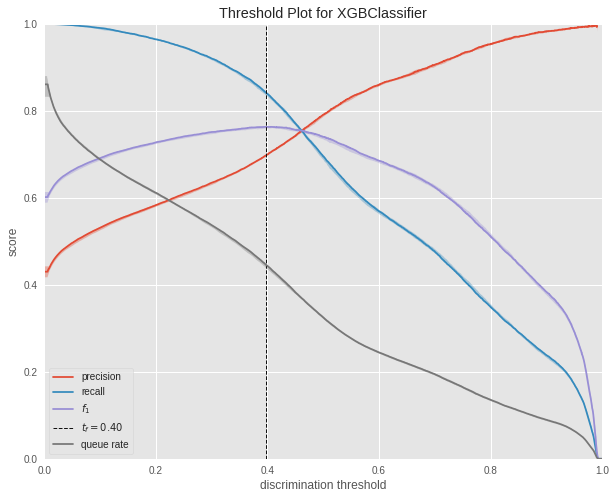

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
boost = xgb.XGBClassifier(max_depth=4, tree_method='gpu_hist', gpu_id=0, eta=0.02, eval_metric=['logloss', 'error'], num_boost_rounds=5000, early_stopping_rounds=100)
visualizer = DiscriminationThreshold(boost, n_trials=5, quantiles=np.array([0.1, 0.5, 0.9]), ax=ax)
visualizer.fit(X, y)
visualizer.show()

XGBoost Classification Report
               precision    recall  f1-score   support

         0.0       0.86      0.89      0.87     50964
         1.0       0.80      0.75      0.77     29894

    accuracy                           0.84     80858
   macro avg       0.83      0.82      0.82     80858
weighted avg       0.84      0.84      0.84     80858



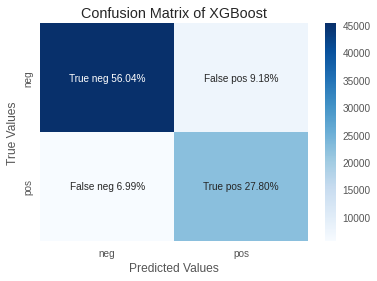

In [22]:
def scr(clf, d_val, ytrue):
        y_pred = (clf.predict(d_test) >= 0.5).astype(int)
        cm = confusion_matrix(y_pred, y_test)
        cats = ['neg', 'pos']
        groups = ['True neg', 'False pos', 'False neg', 'True pos']
        group_percents = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
        labels = [f'{v1} {v2}' for v1, v2 in zip(groups, group_percents)]
        labels = np.asarray(labels).reshape(2, 2)
        sns.heatmap(cm, annot=labels, cmap='Blues', xticklabels=cats, yticklabels=cats, fmt='')
        plt.xlabel('Predicted Values')
        plt.ylabel('True Values')
        plt.title(f'Confusion Matrix of XGBoost')
        print(f'XGBoost Classification Report\n', classification_report(y_test, y_pred))
scr(bst, d_test, y_test)

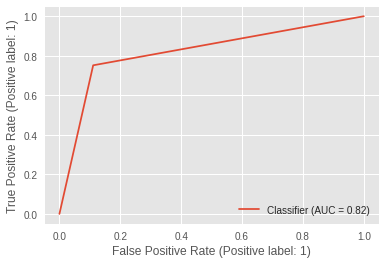

In [19]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, xgb_preds)
plt.show()

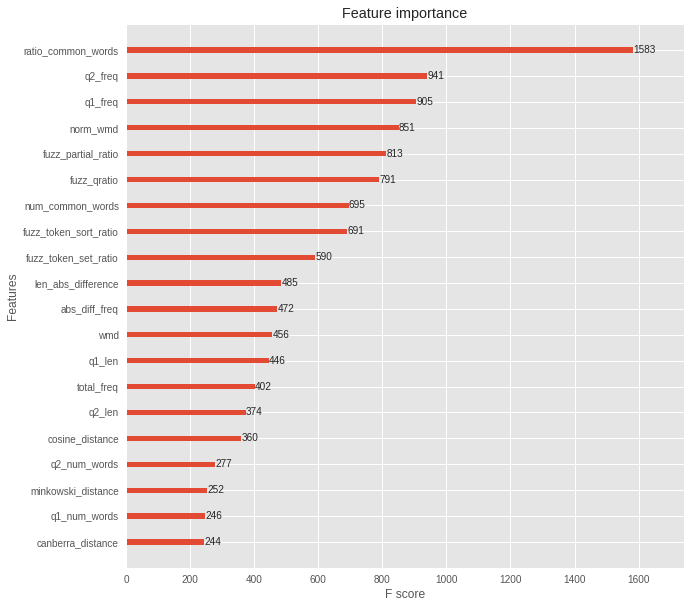

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
xgb.plot_importance(bst, max_num_features=20, ax=ax)
plt.show()